![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# Reinforcement Learning
# Assignment 2
## Introduction
Welcome to the second RL assignment.  This week, we'll dive in to Model-Free Prediction & Control with Temporal Difference (TD) and Q-Learning. See how it is implemented. <br/>
TD-Learning is a combination of Monte Carlo and Dynamic Programming ideas. Like Monte Carlo, TD works based on samples and doesn't require a model of the environment.<br/>
You will be implementing an example of Off-Policy TD Control (SARSA) and another of On-policy TD Control (Q-Learning).  

## Resources
I've always found experience the best teacher, so I advocate just diving in and trying to implement things.  However, it is always good to have other sources to reference, so every week I'll place links to things that I think are helpful to learn the material.
* [Chapters 7 and 12 of this book](http://incompleteideas.net/book/bookdraft2018jan1.pdf) about Multi-Step Bootstrapping and Eligibility Traces is nice.

## the Cliff Walking problem
For implementing your Q-learning algorithm we are going to use the Cliff Walking problem. 



### Introduction (Q-Leaning)
Start by constructing a table that measure how good is to take a specific action at any state (we can measure this by using a simple scalar value, so the greater the value the better the action) These are the **Q-values**. <br/>
**Q-values** are estimates of the sum of future rewards. <br/>
In other words, they estimate how much more reward we can win until the end of the game being at state S and taking action A. <br/>
For our **Cliff Walking problem**, this table will have one row for each state and one column for each action. Our grid world has 48 (4 x 12) states and 4 actions are allowed **(right, left, up, down)**, so the table would be 48 x 4.
<img src="../images/cliff-walking.png" alt="Drawing" style="width: 500px;"/>

Will need to initialize it with random values (or some constant, e.g. all zeroes). <br/>
The optimal Q-table has values that allow us to take the best action at every state, giving us the best path to victory!
The Q-learning algorithm 'learns' these values. At every step we gain more information about the world and this information is used to update the values in the table. <br/>
For example, suppose we are one step away from the goal **(square [2, 11])**, if we choose to go down we’ll receive a reward of 0 instead of -1.
We can use this information to update the value of this state-action pair in our table so that the next time we visit it we already know that going down gives us a reward of 0.<br/>
Now we can propagate this information even further! <br/>
Since we now know the path to the goal from square [2, 11], any action that takes us to square [2, 11] will also be good, so we update the Q-value of the square that lead us to [2, 11] to be closer to 0.<br/>
Note that every time we reach the goal we increase our “map” of how to reach the goal by one square, so after a sufficient number of iterations we’ll have a complete map, that will show us how to get to the goal from every state. <br/>
ref. https://medium.com/@lgvaz/understanding-q-learning-the-cliff-walking-problem-80198921abbc

### Bellman Equation
The equation states that the Q value for a certain state-action pair should be the reward gained by the moving to the new state (by executing that action) added to the value of the best action in the next state:
<img src="../images/bellman_equation.png" alt="Drawing" style="width: 300px;"/>
We might think that receiving a reward right now is more valuable than receiving a reward on the future, and that’s why we have γ, a number between 0 and 1 (generally between 0.9 and 0.99) that get’s multiplied to the future reward, making future rewards discounted.<br/>
As an example, considering γ = 0.9 and applying this to some states of our grid world we have:
<img src="../images/bellman_example.png" alt="Drawing" style="width: 500px;"/>


### The Cliff Walking Environment
The next cells implement the class GridWorld for the Cliff Walking problem that you are going to use. <br/>
We will define the numerical values for the actions (UP, DOWN, RIGHT, LEFT). <br/>
When we instantiate the environment, the class shows see the initial grid.
Take some time to explore the atributes and functions offered by the class to act on the environment before going to solve the questions.

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import seaborn as sns

In [4]:
def change_range(values, vmin=0, vmax=1):
    start_zero = values - np.min(values)
    return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin

In [5]:
class GridWorld:
    terrain_color = dict(normal=[127/360, 0, 96/100],
                         objective=[26/360, 100/100, 100/100],
                         cliff=[247/360, 92/100, 70/100],
                         player=[344/360, 93/100, 100/100])
        
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid):
        grid[-1, 1:11] = self.terrain_color['cliff']
        grid[-1, -1] = self.terrain_color['objective']
        
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor')       
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], '0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(12 * 4)]     
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        
    def reset(self):
        self.player = (3, 0) 
        #print("INITIAL POSITION: {}, STATE: {}".format(self.player,self._position_to_id(self.player)))
        return self._position_to_id(self.player), self.player
    
    def step(self, action):
        # Possible actions
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
            
        # Rules
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
        #print("NEXT STATE: {}".format(self.player))
        
        return self.player, self._position_to_id(self.player), reward, done
    
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * 12 + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12)
        
    def render(self, q_values=None, action=None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
            values = change_range(np.max(q_values, -1)).reshape(4, 12)
            grid[:, :, 1] = values
            self._add_objectives(grid)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if q_values is not None:
            xs = np.repeat(np.arange(12), 4)
            ys = np.tile(np.arange(4), 12)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)
                
        if action is not None:
            self.ax.set_title(action, color='r', weight='bold', fontsize=32)

        plt.pause(0.01)

In [6]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']

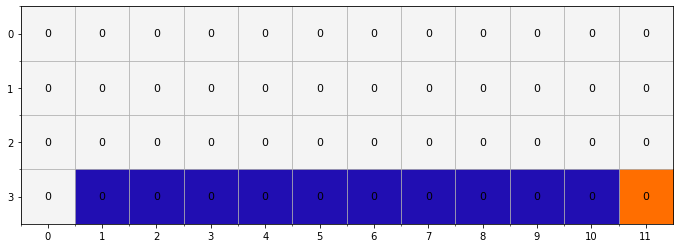

In [7]:
env = GridWorld()

In [20]:
env.grid.shape

(4, 12, 3)

# PART 1 - Off Policy TD Control

**Off Policy** means that the learning agent learns the value function according to the action derived from another policy.<br/>

We consider that: 
+ **Update policy** is how your agent learns the optimal policy.
+ **Behavior policy** is how your agent behaves.

In Q-Learning, the agent learns optimal policy using absolute greedy policy and behaves using other policies such as ϵ-greedy policy. 

As the *update policy* is different to the *behavior policy*, Q-learning is called **Off-policy**.

## Question 1
Implement a Q-Learning function that runs for **500 episodes**, with **exploration rate** = 0.1, **learning rate** = 0.5 and **gamma** = 0.9. <br/>
This function should return a list with the **sum of rewards of each episode** and the **final Q-value table**.<br/>
Execute the function and use its returns to:
+ Print the mean of rewards for all episode
+ Print the Q-value table

You are going to use the Q-learning pseudo-code from Sutton’s book as a guide.
<img src="../images/Q-learning.png" alt="Drawing" style="width: 700px;"/>

#### Notes
+ First it says “For all states and actions initialize Q(s,a) arbitrarily”, this means you could create your Q-values table with any values you like, they can be random, they can be some constant, doesn’t matter.

+ It also says “Q value for terminal states equals zero”. you can’t take any actions at terminals states, so we consider the value for all actions on that state to be zero.

+ To perform the actions and get the needed values from the Cliff Walking environment, use the functions offered by the class, like reset, step, etc.
+ Also, use the **egreedy_policy** function below in your algorithm.

In [24]:
def egreedy_policy(q_values, state, epsilon=0.1):
    """ 
    Choose an action based on a epsilon greedy policy.    
    A random action is selected with epsilon probability, else select the best action.
            
    Args:
        q_values: Q-value table.
        state: current state (in the format of the first value returned by the step function in the GridWorld class. 
        epsilon: The epsilon probability.
                        
    Returns:
        The best action for the state. 
        Logical variable: True for random choice selected, False for best action selected.
    """
    if np.random.random() < epsilon:
        #print(">>>>>>>>>> RANDOM ACTION")
        random_choice = True
        return np.random.choice(4), random_choice
    else:
        #print(">>>>>>>>>> q_values[{}]: {}, BEST ACTION FOR CURRENT STATE: {}" \
        #          .format(state, q_values[state], np.argmax(q_values[state])))
        random_choice = False
        return np.argmax(q_values[state]), random_choice

In [40]:
egreedy_policy(q_values, state, exploration_rate)

(0, False)

In [52]:
def q_learning(env, num_episodes=500, exploration_rate=0.1, learning_rate=0.5, gamma=0.9):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: GridWorld environment for Cliff Walking.
        num_episodes: Number of episodes to run for.
        exploration_rate: Chance to sample a random action. Float between 0 and 1 (epsilon probability).
        learning_rate: TD learning rate. Avoid big changes in only one update by slowly moving to the target.
        gamma: A discount factor for future rewards.
    
    Returns:
        ep_rewards: list of sum of rewards per episode
        q_value: The optimal action-value function, a dictionary mapping state -> action values.
    """

    #Define the state matrix
    num_states = 4 * 12
    num_actions = 4

    q_values = np.zeros((num_states, num_actions))
    ep_rewards = []

    for e in range(num_episodes):
        state, state_coord = env.reset()
        done = False

        reward_sum = 0
        while not done:
            # get action
            action, random_choice = egreedy_policy(q_values, state, exploration_rate)
            # take action get next step state, reward
            next_state_cood, next_state, reward, done = env.step(action)
            reward_sum += reward

            td_target = reward + gamma * np.max(q_values[next_state])
            td_error = td_target - q_values[state][action]
            q_values[state][action] += learning_rate * td_error
            state = next_state
        ep_rewards.append(reward_sum)


#         if e % 100 == 0:
#             print("")
#             print("Q-table after " + str(e+1) + " iterations:") 
#             df_q_values = pd.DataFrame(q_values, columns=[' up ', 'down', 'right', 'left'])
#             df_q_values.index.name = 'States'
#             print(df_q_values)

    return ep_rewards, q_values

In [53]:
q_learning_rewards, q_values = q_learning(env)
np.mean(q_learning_rewards)

-42.414

In [54]:
df_q_values = pd.DataFrame(q_values, columns=[' up ', 'down', 'right', 'left'])
df_q_values.index.name = 'States'
df_q_values

,up,down,right,left
States,,,,
0,-6.900189,-7.073197,-6.882945,-6.968712
1,-6.655876,-6.770149,-6.707020,-6.718065
2,-6.517045,-6.507473,-6.502350,-6.632282
3,-6.226464,-6.287385,-6.227790,-6.483582
4,-5.951872,-5.874138,-5.876602,-6.000692
5,-5.648402,-5.503176,-5.477291,-5.799804
6,-5.217582,-5.071197,-5.034259,-5.138895
7,-4.827563,-4.625564,-4.530159,-4.796952
8,-4.012631,-4.013703,-3.977752,-4.202957


## Question 2
You have used the ϵ-greedy function below in your algorithm. <br/>
Explain why is important to implement **exploration** in this algorithm ϵ-greedy that you've used.

## Question 2 Answer here ###
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

## Question 3
Execute the function Q-learning 10 times. <br/>
Take the average reward for each step over these 10 executions and plot this Average Reward vs Episodes, to see how the rewards evolve through the episodes.<br/>
Show, in the same plot, the line representing the mean of rewards above related to all episodes, as a reference.

Mean Reward: -41.3774


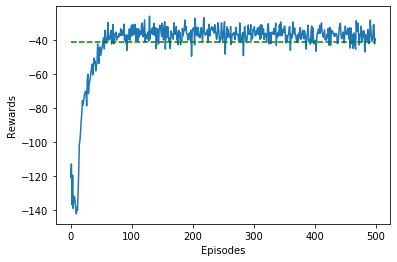

In [64]:
q_learning_rewards, _ = zip(*[q_learning(env, exploration_rate=0.1, learning_rate=1) for _ in range(100)])
avg_rewards = np.mean(q_learning_rewards,axis=0)
mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)

fig, ax = plt.subplots()
ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')
print('Mean Reward: {}'.format(mean_reward[0]))

## Question 4
Modify the function q_learning that you have just created to plot for each episode a heatmap showing how many times a position in the grid is visited.<br/>
Print only the first 10 and the last 10 episodes form the total of 500 episodes. <br/>
Yor heatmap should represent our Cliff Walking grid like the example below:
<table><tr><td><img src="../images/QL-episode5.png" alt="Drawing" style="width: 300px;"/></td></tr></table>

Note that: 
+ Position (3,0): initial position
+ Position (3,11): terminal position
+ Position (3,1) to (3,10): cliff


+ Explain what you've observed about the pattern evolution related to the positions visited over the episodes. <br/>

### Optional
Force a bigger number for positions visited by exploratory steps (like 100) to better observe them on the heatmap.


In [71]:
def q_learning_with_heatmap(env, num_episodes=500, exploration_rate=0.1, learning_rate=0.5, gamma=0.9):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: GridWorld environment for Cliff Walking.
        num_episodes: Number of episodes to run for.
        exploration_rate: Chance to sample a random action. Float between 0 and 1 (epsilon probability).
        learning_rate: TD learning rate. Avoid big changes in only one update by slowly moving to the target.
        gamma: A discount factor for future rewards.
    
    Returns:
        ep_rewards: list of sum of rewards per episode
        q_value: The optimal action-value function, a dictionary mapping state -> action values.
    """

    #Define the state matrix
    num_states = 4 * 12
    num_actions = 4

    q_values = np.zeros((num_states, num_actions))
    ep_rewards = []

    for e in range(num_episodes):
        state, state_coord = env.reset()
        done = False
        feature_list = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
        zero_data = np.zeros(shape=(4,12))
        df_state_coord = pd.DataFrame(zero_data, columns=feature_list)
        df_state_coord.iloc[state_coord[0], state_coord[1]] = 1
        reward_sum = 0
        while not done:
            # get action
            action, random_choice = egreedy_policy(q_values, state, exploration_rate)
            # take action get next step state, reward
            next_state_coord, next_state, reward, done = env.step(action)
            if random_choice:
                df_state_coord.iloc[next_state_coord[0], next_state_coord[1]] = 100
            else:
                df_state_coord.iloc[next_state_coord[0], next_state_coord[1]] += 1
            reward_sum += reward

            td_target = reward + gamma * np.max(q_values[next_state])
            td_error = td_target - q_values[state][action]
            q_values[state][action] += learning_rate * td_error
            state = next_state
        ep_rewards.append(reward_sum)


        if e < 10 or e > (num_episodes -10):
            ax = sns.heatmap(df_state_coord, linewidth=0.5, cmap='gray_r',vmin=0, vmax=5, annot=True)
            plt.title("EPISODE "+str(e))
            plt.show()

    
    return ep_rewards, q_values

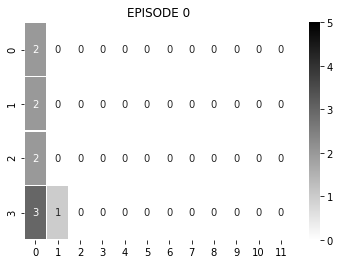

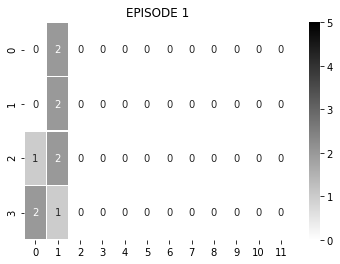

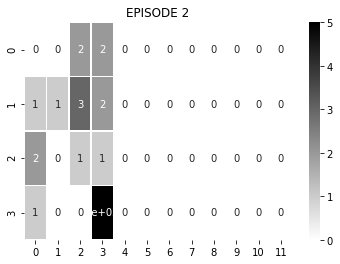

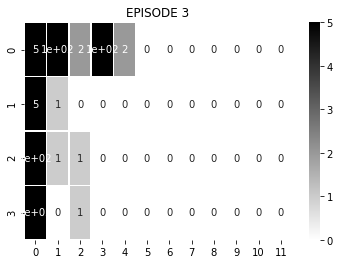

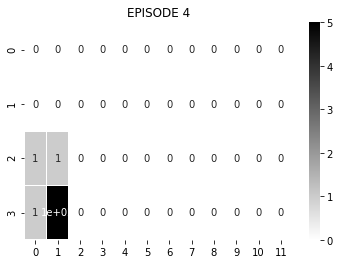

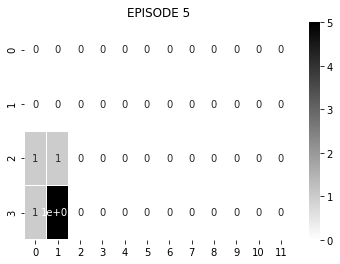

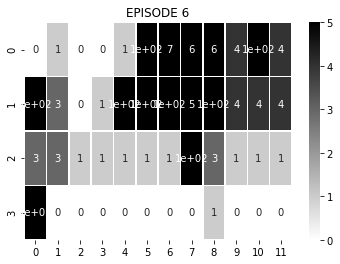

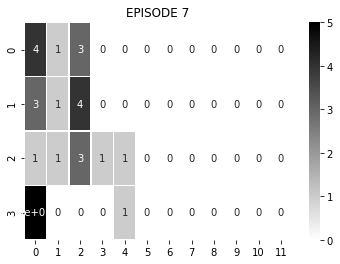

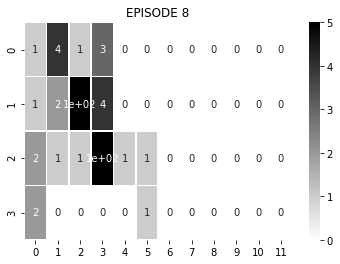

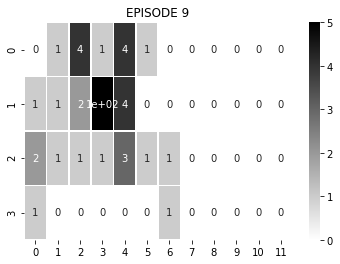

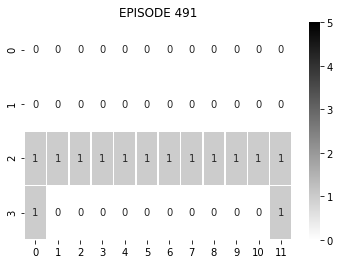

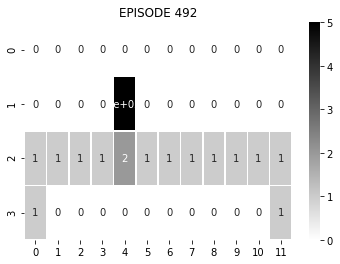

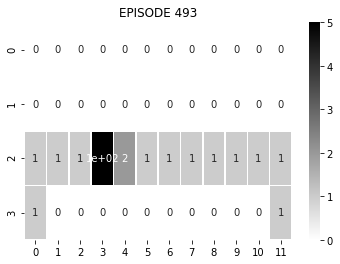

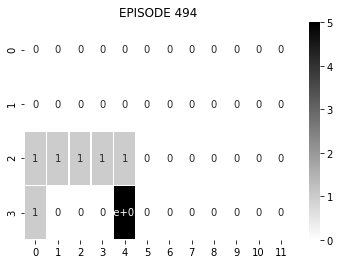

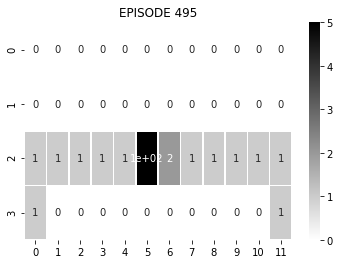

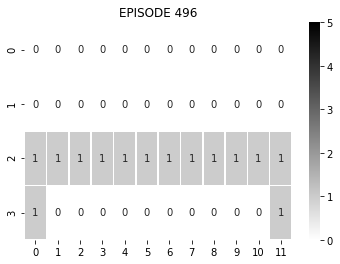

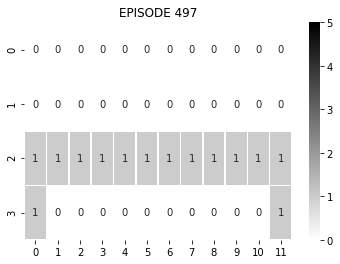

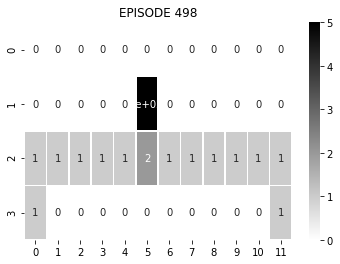

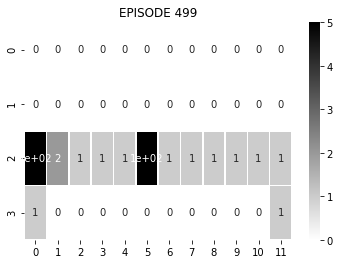

In [72]:
q_learning_rewards, q_values = q_learning_with_heatmap(env, gamma=0.9, learning_rate=1)

# PART 2 - On Policy TD Control

**On Policy** means that the learning agent learns the value function according to the current action derived from the policy currently being used.

Again, consider that: 
+ **Update policy** is how your agent learns the optimal policy.
+ **Behavior policy** is how your agent behaves.

In SARSA, the agent learns optimal policy and behaves using the same policy such as ϵ-greedy policy. 

As the *update policy* is the same to the *behavior policy*, SARSA is called **On-policy**. <br/>

The difference can be observed comparing the SARSA update equation with the previous one that you used for Q-learning:

<img src="../images/Q-learning_SARSA.png" alt="Drawing" style="width: 400px;"/>

Here, the update equation for SARSA depends on the current state, current action, reward obtained, next state and next action. <br/>
This observation lead to the naming of the learning technique as SARSA stands for State Action Reward State Action which symbolizes the tuple (s, a, r, s’, a’).

## Question 5
Based on the code that you have created for your Q-learning function in the last question (the one that implemented the hetmap for each episode), implement a SARSA function that runs for **500 episodes**, with **exploration rate** = 0.1, **learning rate** = 0.5 and **gamma** = 0.9. <br/>

This function should return a list with the **sum of rewards of each episode** and the **final Q-value table**.<br/>

+ Looking at the final 10 episodes, can you explain the main difference observed bettwen the SARSA and Q-learning heatmaps?

You are going to use the Q-learning pseudo-code from Sutton’s book as a guide.
<img src="../images/Q-learning.png" alt="Drawing" style="width: 700px;"/>

In [73]:

def sarsa_with_heatmap(env, num_episodes=500, exploration_rate=0.1, learning_rate=0.5, gamma=0.9):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: GridWorld environment for Cliff Walking.
        num_episodes: Number of episodes to run for.
        exploration_rate: Chance to sample a random action. Float between 0 and 1 (epsilon probability).
        learning_rate: TD learning rate. Avoid big changes in only one update by slowly moving to the target.
        gamma: A discount factor for future rewards.
    
    Returns:
        ep_rewards: list of sum of rewards per episode
        q_value: The optimal action-value function, a dictionary mapping state -> action values.
    """
    #Define the state matrix
    num_states = 4 * 12
    num_actions = 4

    q_values = np.zeros((num_states, num_actions))
    ep_rewards = []

    for e in range(num_episodes):
        state, state_coord = env.reset()
        done = False
        # choose action
        action, random_choice = egreedy_policy(q_values, state, exploration_rate)
        feature_list = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
        zero_data = np.zeros(shape=(4,12))
        df_state_coord = pd.DataFrame(zero_data, columns=feature_list)
        df_state_coord.iloc[state_coord[0], state_coord[1]] = 1
        reward_sum = 0
        while not done:
            # take action get next step state, reward
            next_state_coord, next_state, reward, done = env.step(action)
            if random_choice:
                df_state_coord.iloc[next_state_coord[0], next_state_coord[1]] = 100
            else:
                df_state_coord.iloc[next_state_coord[0], next_state_coord[1]] += 1
            reward_sum += reward
            
            # choose next action
            next_action, random_choice = egreedy_policy(q_values, next_state, exploration_rate)

            # q learning
            # td_target = reward + gamma * np.max(q_values[next_state])
            # sarsa
            td_target = reward + gamma * q_values[next_state][next_action]
            td_error = td_target - q_values[state][action]
            q_values[state][action] += learning_rate * td_error
            state = next_state
            action = next_action
        ep_rewards.append(reward_sum)


        if e < 10 or e > (num_episodes -10):
            ax = sns.heatmap(df_state_coord, linewidth=0.5, cmap='gray_r',vmin=0, vmax=5, annot=True)
            plt.title("EPISODE "+str(e))
            plt.show()

    
    return ep_rewards, q_values

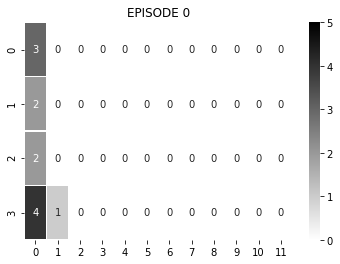

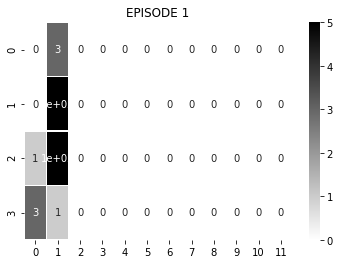

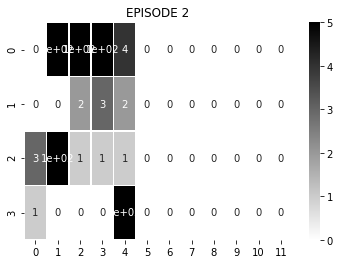

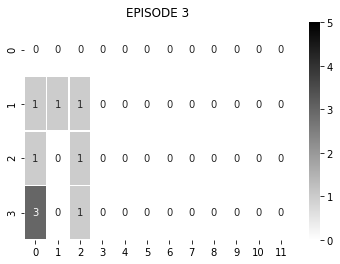

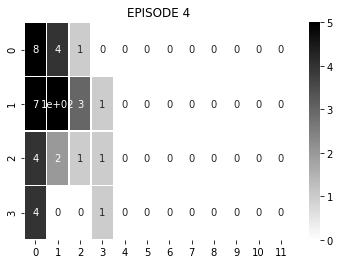

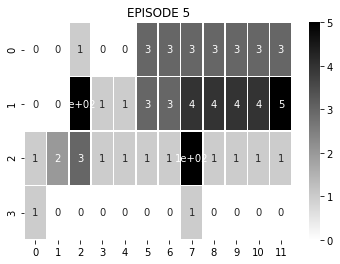

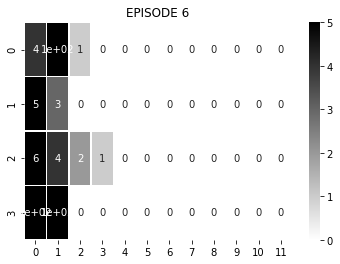

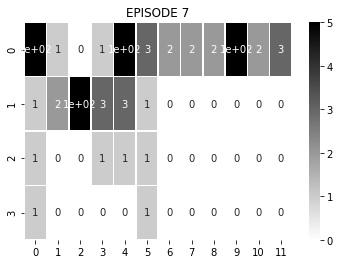

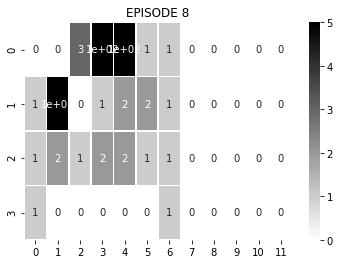

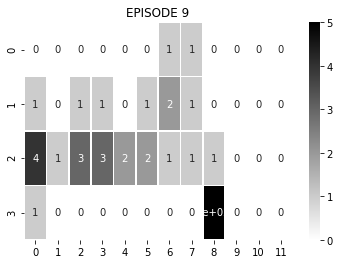

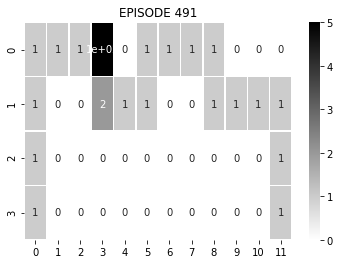

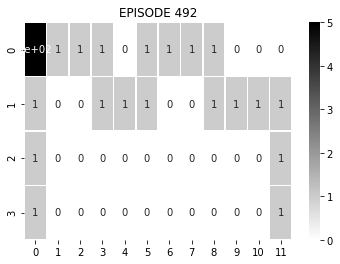

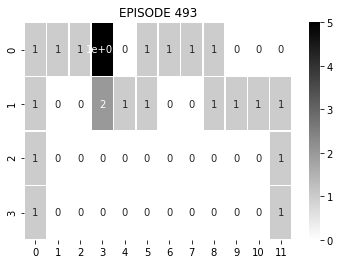

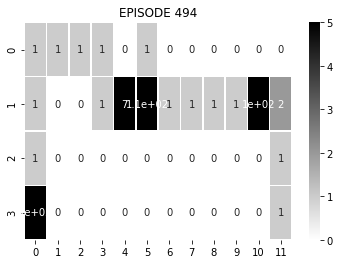

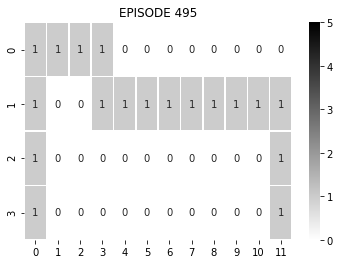

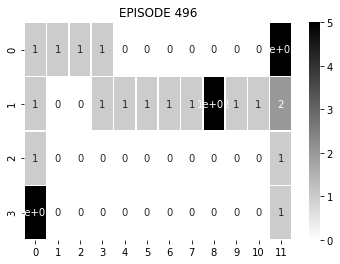

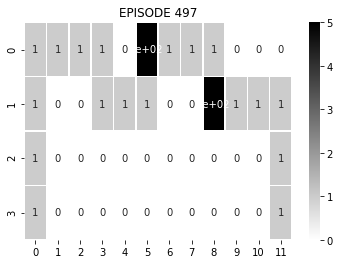

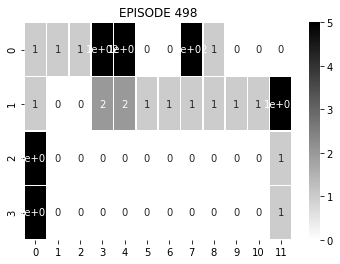

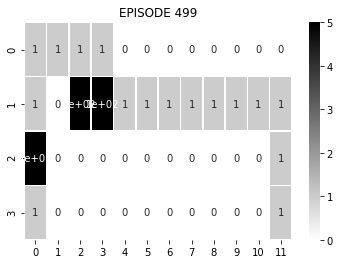

In [74]:
sarsa_rewards, q_values_sarsa = sarsa_with_heatmap(env, learning_rate=0.5, gamma=0.99)